# Inicial preparations

In [32]:
#!pip install pytorch-tabnet wget
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.tree import export_graphviz
from sklearn import metrics
from xgboost import plot_tree
import pandas as pd
import numpy as np
import os
import wget
from pathlib import Path
import shutil
import gzip
import joblib
import pydot

random_state=42
np.random.seed(random_state)

from matplotlib import pyplot as plt
#%matplotlib inline

#Display information about dataframe
def displayInformationDataFrame(df_cop):
    summary_df = pd.DataFrame(columns=['Data Type', 'Column Name', 'Unique Values'])
    # Iterate through the columns of the original dataframe
    for col in df_cop.columns:
        # Get the data type of the column
        dtype = df_cop[col].dtype
        # Get the column name
        col_name = col
        # Get the unique values of the column
        unique_values = df_cop[col].unique()
        # Append a new row to the summary dataframe
        summary_df = summary_df.append({'Data Type': dtype, 'Column Name': col_name, 'Unique Values': unique_values}, ignore_index=True)
    # display the summary_df
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    #return display(summary_df)

def calcula_metricas(nome_modelo, ground_truth, predicao):
  """
    Funcão Auxiliar para calcular e imprimir métricas: Tx de Acerto, F1, 
    Precisão, Sensibilidade e AUC
  """
  acc = accuracy_score(y_true = ground_truth, y_pred = predicao)
  f1 = f1_score(y_true = ground_truth, y_pred = predicao,average='weighted')
  precision = precision_score(y_true = ground_truth, y_pred = predicao,average='weighted')
  recall = recall_score(y_true = ground_truth, y_pred = predicao,average='weighted')
  #auc_sklearn = roc_auc_score(y_true = ground_truth, y_score = predicao, multi_class='ovr')

  print(f"Desempenho {nome_modelo} - Conjunto de Teste")
  print(f' Taxa de Acerto: {np.round(acc*100,2)}%\n Precisão: {np.round(precision*100,2)}%')
  print(f' Sensibilidade: {np.round(recall*100,2)}%\n Medida F1: {np.round(f1*100,2)}%')
  #print(f' Área sob a Curva: {np.round(auc_sklearn*100,2)}%')

#sys.setrecursionlimit(1000000) 

df = pd.read_csv('../../data/DNN-EdgeIIoT-dataset.csv', low_memory=False)
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
         "tcp.dstport", "udp.port", "mqtt.msg"]

df.drop(drop_columns, axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)
df = shuffle(df)

categorical_columns = []
for col in df.columns[df.dtypes == object]:
    if col != "Attack_type":
        categorical_columns.append(col)

featuresFromStart = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]]
#print("-----Features from the start-----")
#print(featuresFromStart)
#print("-----Categorial features-----")
#print(categorical_columns)
    
displayInformationDataFrame(df)

colunas_one_hot = {}
for coluna in categorical_columns:
    codes, uniques = pd.factorize(df[coluna].unique())
    colunas_one_hot[coluna] = {"uniques": uniques, "codes":codes}
    df[coluna] = df[coluna].replace(colunas_one_hot[coluna]["uniques"], colunas_one_hot[coluna]["codes"])
    print(coluna)
df = pd.get_dummies(data=df, columns=categorical_columns)
displayInformationDataFrame(df)

http.request.method
http.referer
http.request.version
dns.qry.name.len
mqtt.conack.flags
mqtt.protoname
mqtt.topic


In [33]:
for attackType in df["Attack_type"].unique():
    print(attackType + " - " + str(len(df[df["Attack_type"] == attackType])))

DDoS_HTTP - 48544
Uploading - 36807
Normal - 1363998
Backdoor - 24026
DDoS_ICMP - 67939
DDoS_UDP - 121567
SQL_injection - 50826
Vulnerability_scanner - 50026
Port_Scanning - 19977
Password - 49933
DDoS_TCP - 50062
XSS - 15066
Ransomware - 9689
Fingerprinting - 853
MITM - 358


In [34]:
df_before = df
df_attacks = df[df["Attack_type"] != "Normal"]

print(len(df))
df_normal = df[df["Attack_type"] == "Normal"]
print(len(df_normal))

1909671
1363998


In [35]:

df_normal = shuffle(df_normal)
df_normal = df_normal[:500000]
#df_normal.head(len(df) - 800000)
#df_normal.drop(df_normal.loc[0:800000].index, inplace=True)
print(len(df_normal))

500000


In [36]:
df = pd.concat([df_attacks,df_normal])

In [37]:
df = shuffle(df)
n_total = len(df)

features = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]] 

le = LabelEncoder()
le.fit(df["Attack_type"].values)

train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=random_state)
#train_indices, valid_indices = train_test_split(train_val_indices, test_size=0.25, random_state=random_state) # 0.25 x 0.8 = 0.2

X_train = df[features].values[train_val_indices]
y_train = df["Attack_type"].values[train_val_indices]
y_train = le.transform(y_train)

#X_valid = df[features].values[valid_indices]
#y_valid = df["Attack_type"].values[valid_indices]
#y_valid = le.transform(y_valid)

X_test = df[features].values[test_indices]
y_test = df["Attack_type"].values[test_indices]
y_test = le.transform(y_test)

standScaler = StandardScaler()
model_norm = standScaler.fit(X_train)

X_train = model_norm.transform(X_train)
X_test = model_norm.transform(X_test)

In [38]:
sm = SMOTE(random_state=random_state,n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

/Users/melicias/.local/lib/python3.7/site-packages/imblearn/over_sampling/_smote/base.py:340: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4825
           1       0.93      0.57      0.71      9704
           2       1.00      1.00      1.00     13624
           3       1.00      1.00      1.00     10157
           4       1.00      1.00      1.00     24299
           5       0.18      0.77      0.30       152
           6       1.00      1.00      1.00        77
           7       1.00      1.00      1.00    100092
           8       0.52      0.68      0.59      9941
           9       0.96      0.87      0.91      3946
          10       0.90      0.91      0.91      1905
          11       0.57      0.55      0.56     10115
          12       0.73      0.46      0.56      7272
          13       0.97      0.89      0.93     10014
          14       0.35      0.89      0.51      3012

    accuracy                           0.91    209135
   macro avg       0.81      0.84      0.79    209135
weighted avg       0.93   

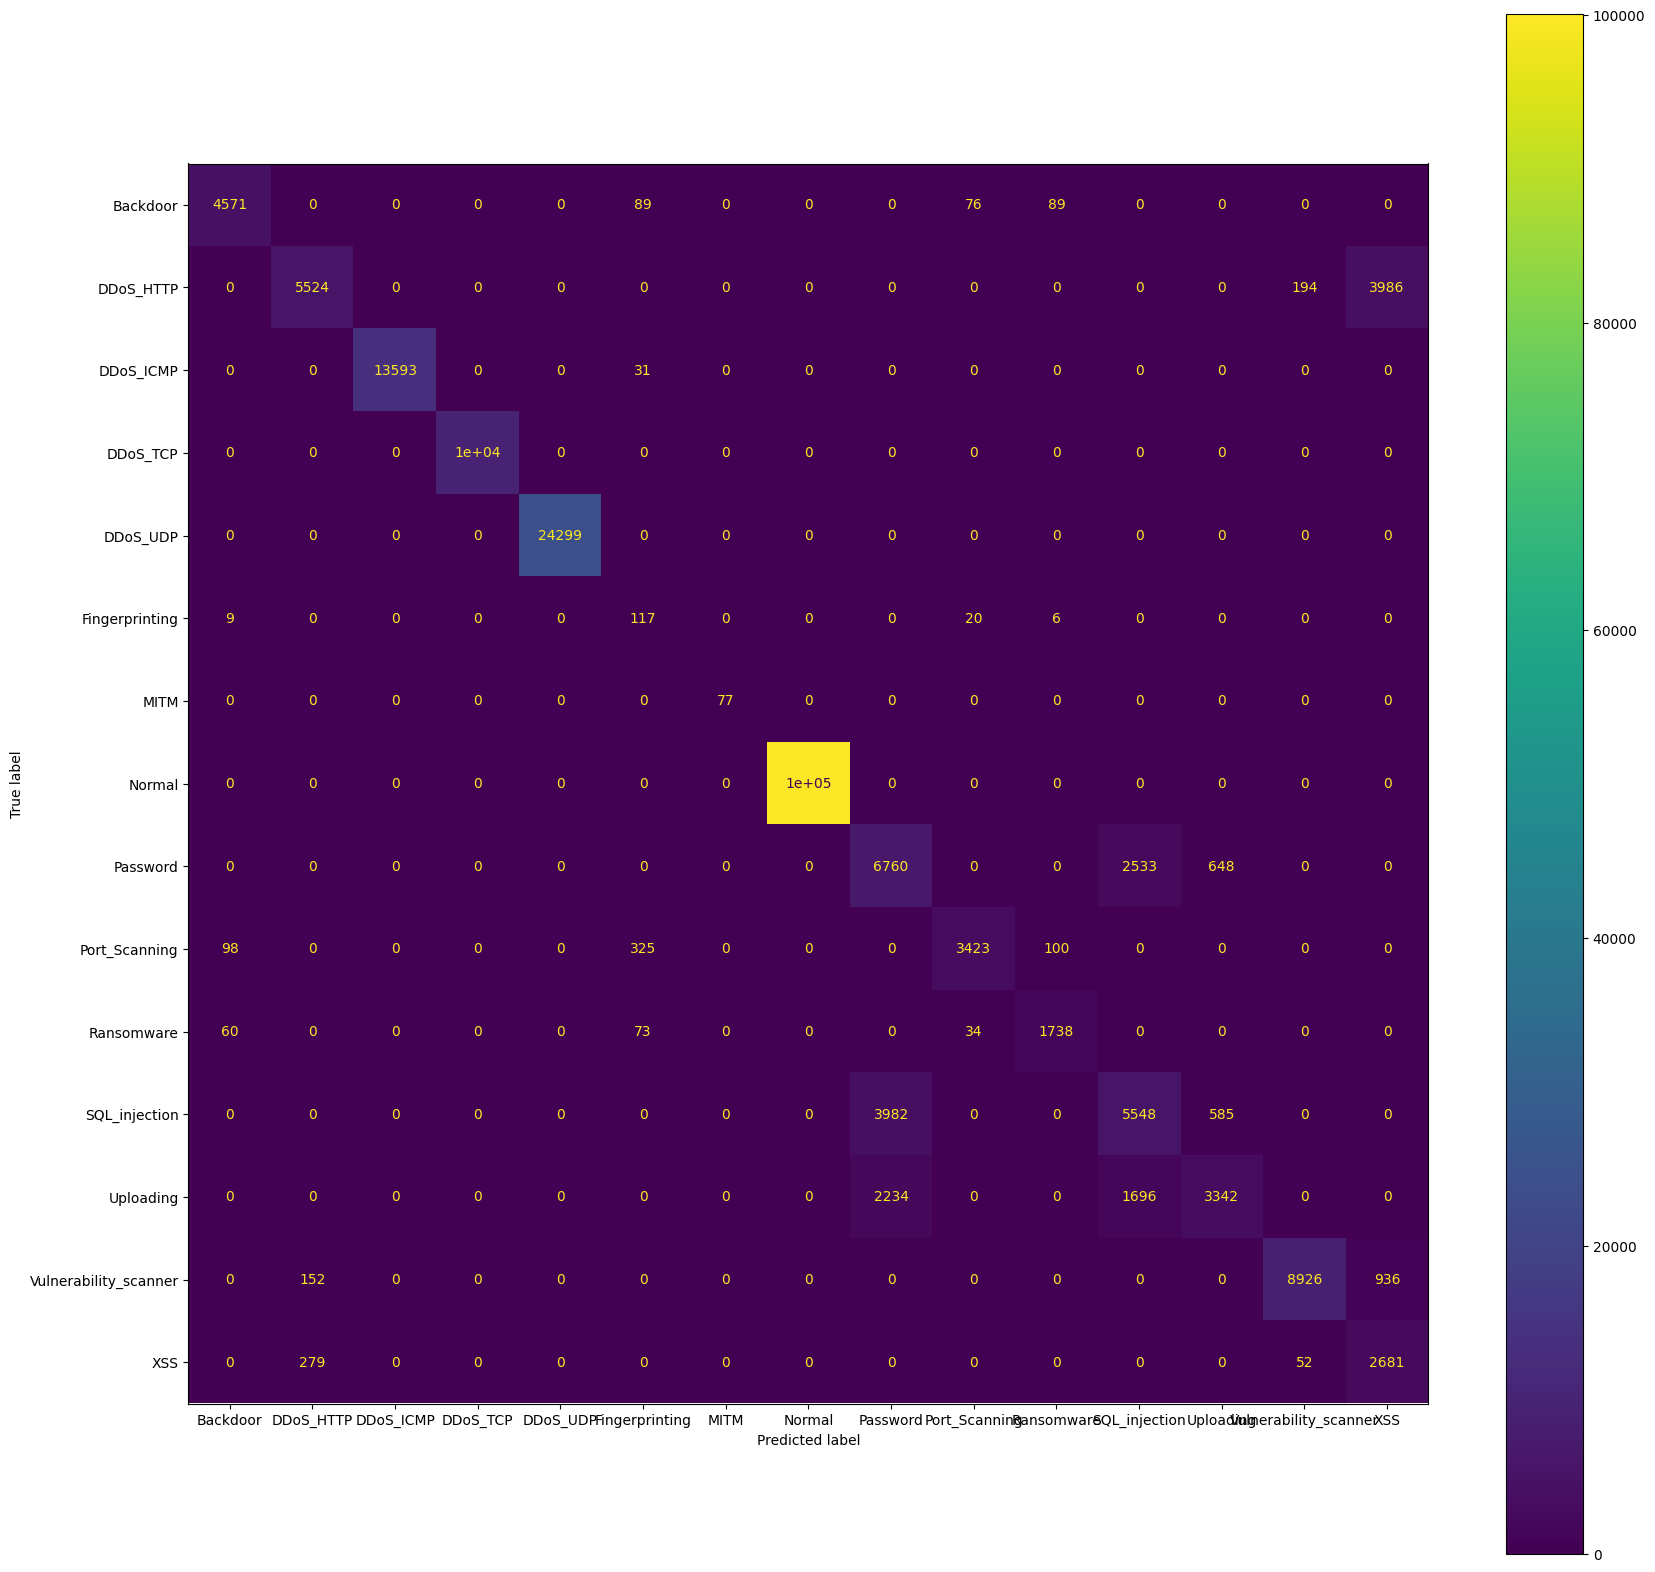

Desempenho Random Forest - Conjunto de Teste
 Taxa de Acerto: 91.26%
 Precisão: 93.0%
 Sensibilidade: 91.26%
 Medida F1: 91.57%


In [39]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = random_state)
# Train the model on training data
rf.fit(X_train, y_train)

joblib.dump(rf, "./modelRandomForest.joblib")
#loaded_rf = joblib.load("./random_forest.joblib")

predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

mask = np.logical_not(np.equal(y_test, predictions))
print(f"Elements wrong classified: {len(X_test[mask])}; Elements correct: {len(X_test) - len(X_test[mask])}")

original_labels_list = le.classes_
fig,ax = plt.subplots(figsize=(20, 20))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels= original_labels_list)
cm_display.plot(ax=ax)
plt.savefig("confusion_matrix.png")
plt.show()

calcula_metricas("Random Forest", y_test, predictions)

# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'treeMulti.dot', feature_names = features, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('treeMulti.dot')
# Write graph to a png file
graph.write_png('treeMulti.png')

print(classification_report(y_test, predictions))
